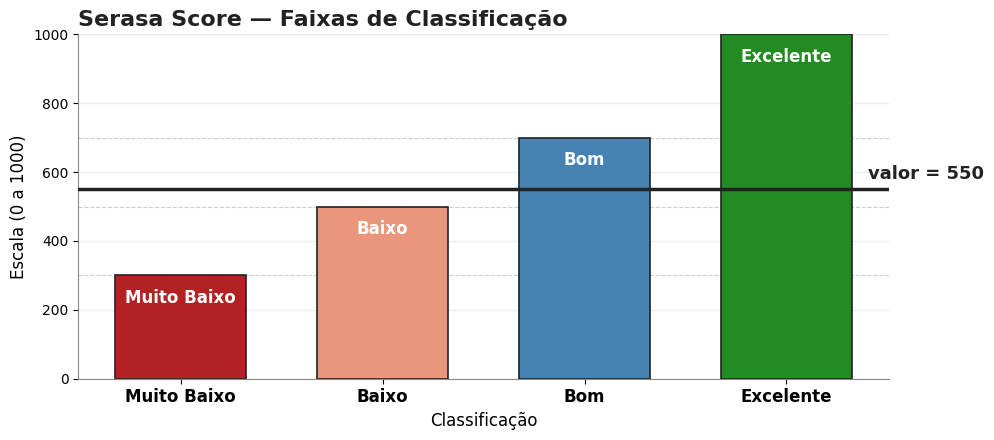

In [ ]:
import matplotlib.pyplot as plt

# Paleta de cores sóbria e elegante
bar_colors = ['#b22222', '#e9967a', '#4682b4', '#228b22']  # vermelho, laranja, azul, verde
score_color = '#222222'

fig, ax = plt.subplots(figsize=(10, 4.5))

# Barras: cada faixa com cor distinta, borda discreta
bars = ax.bar(
    x, tops, width=0.65, color=bar_colors, edgecolor='#222', linewidth=1.2, zorder=2
)

# Linhas horizontais para separar as faixas
for _, hi in ranges:
    ax.axhline(hi, color='#cccccc', linestyle='--', linewidth=0.8, zorder=1)

# Linha do score observado
ax.axhline(score, color=score_color, linewidth=2.5, linestyle='-', zorder=3)
ax.text(
    len(classes) - 0.02, score + 18, f"valor = {score}", 
    va="bottom", ha="right", fontsize=13, fontweight='bold', color=score_color, zorder=4
)

# Rótulos das faixas no topo das barras
for i, (label, hi) in enumerate(zip(classes, tops)):
    ax.text(
        i, hi - 40, label, ha='center', va='top', fontsize=12, color='white', fontweight='bold'
    )

# Eixo x e y
ax.set_xticks(x)
ax.set_xticklabels(classes, fontsize=12, fontweight='bold')
ax.set_ylim(0, 1000)
ax.set_yticks(np.arange(0, 1100, 200))
ax.set_ylabel("Escala (0 a 1000)", fontsize=12)
ax.set_xlabel("Classificação", fontsize=12)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#888')
ax.spines['bottom'].set_color('#888')

# Título elegante
ax.set_title(
    "Serasa Score",
    loc="left", fontsize=16, fontweight='bold', color='#222'
)

plt.grid(axis='y', color='#eeeeee', linestyle='-', linewidth=1, zorder=0)
plt.tight_layout()
plt.show()
